## Importing libraries

In [ ]:
#importing libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

## Downloading Apple Stock data for 5 years (2018-2023)

In [ ]:
# Download historical stock price data
stock_symbol = 'AAPL'
data = yf.download(stock_symbol, start='2018-01-01', end='2023-01-01')

# Display the first few rows of the dataframe
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.615898,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.608803,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.797443,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.261936,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.108677,82271200


## Data exploration & Plots for visulization

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


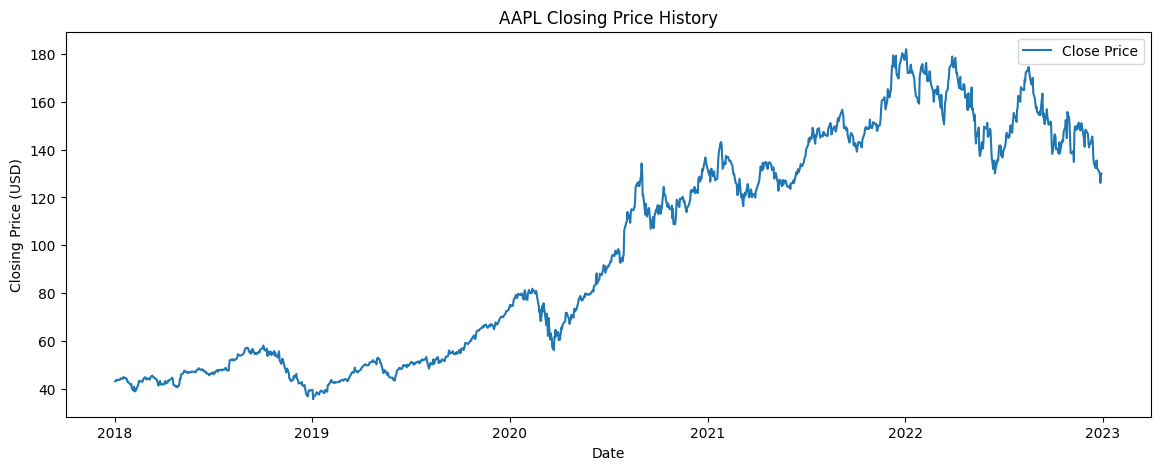

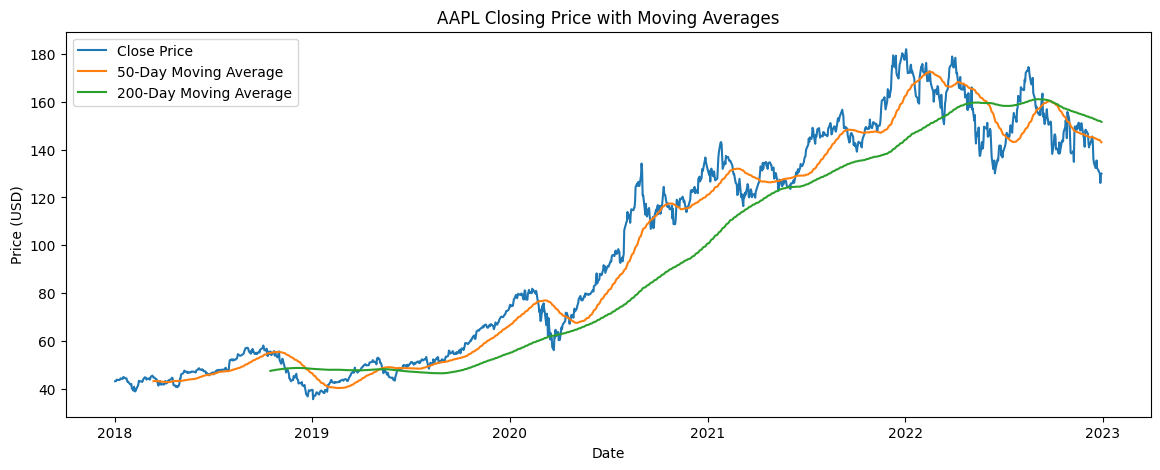

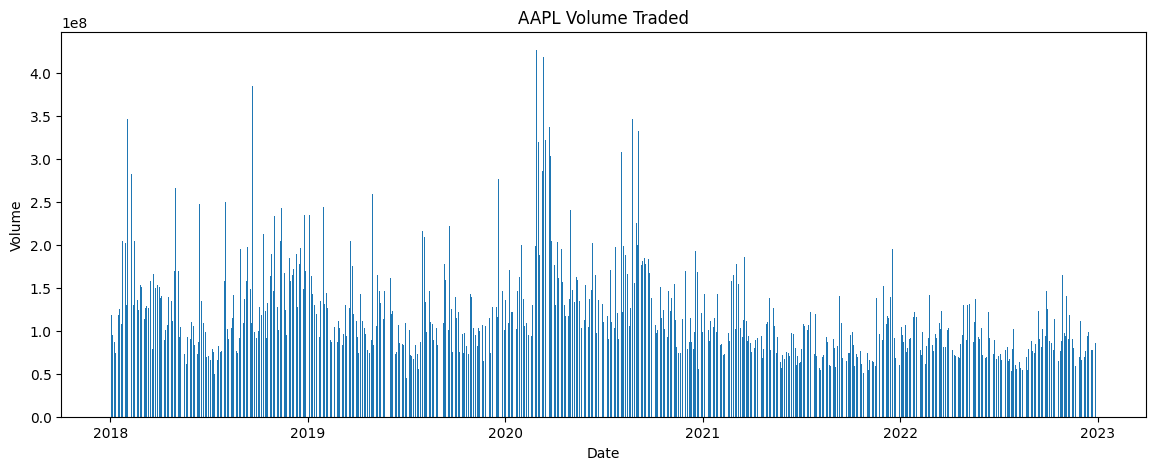

In [ ]:
# Display basic information about the data
data.info()

# Display summary statistics
data.describe()

# Plot the closing price history
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{stock_symbol} Closing Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

# Plot moving averages
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA50'], label='50-Day Moving Average')
plt.plot(data['MA200'], label='200-Day Moving Average')
plt.title(f'{stock_symbol} Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot volume traded
plt.figure(figsize=(14, 5))
plt.bar(data.index, data['Volume'])
plt.title(f'{stock_symbol} Volume Traded')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


## Data Preprocessing

In [ ]:
# Extract the 'Close' prices
close_prices = data['Close'].values

# Reshape the data to fit the scaler
close_prices = close_prices.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

# Display the scaled data
scaled_close_prices[:5]


array([[0.05132712],
       [0.05127591],
       [0.05264146],
       [0.05600409],
       [0.05489461]])

## Train Test split (80-20)

In [ ]:
# Define the training data size
training_data_size = int(len(scaled_close_prices) * 0.8)

# Split the data
train_data = scaled_close_prices[:training_data_size]
test_data = scaled_close_prices[training_data_size:]

# Display the sizes of the training and test datasets
len(train_data), len(test_data)


(1007, 252)

## Reshaping/Formating data for LSTM model (time step - 60 days)

In [ ]:
def create_sequences(data, time_step=60):
    X = []
    y = []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Create sequences for training and test data
time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the data to be [samples, time steps, features] as required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Display the shapes of the training and test sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((946, 60, 1), (946,), (191, 60, 1), (191,))

## Building Model 1

In [ ]:
# Build the LSTM model
model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

# Compile the model
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model_1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 25)                1275      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training Model 1

Epoch 1/40
30/30 [==============================] - 0s 13ms/step - loss: 5.8168e-04 - val_loss: 0.0025
Epoch 2/40
30/30 [==============================] - 0s 10ms/step - loss: 5.8802e-04 - val_loss: 0.0034
Epoch 3/40
30/30 [==============================] - 0s 9ms/step - loss: 5.8280e-04 - val_loss: 0.0018
Epoch 4/40
30/30 [==============================] - 0s 10ms/step - loss: 5.1108e-04 - val_loss: 0.0017
Epoch 5/40
30/30 [==============================] - 0s 12ms/step - loss: 5.5102e-04 - val_loss: 0.0022
Epoch 6/40
30/30 [==============================] - 0s 9ms/step - loss: 5.0921e-04 - val_loss: 0.0015
Epoch 7/40
30/30 [==============================] - 0s 9ms/step - loss: 5.8384e-04 - val_loss: 0.0030
Epoch 8/40
30/30 [==============================] - 0s 11ms/step - loss: 5.9286e-04 - val_loss: 0.0018
Epoch 9/40
30/30 [==============================] - 0s 10ms/step - loss: 4.6615e-04 - val_loss: 0.0019
Epoch 10/40
30/30 [==============================] - 0s 9ms/step - loss: 4.6

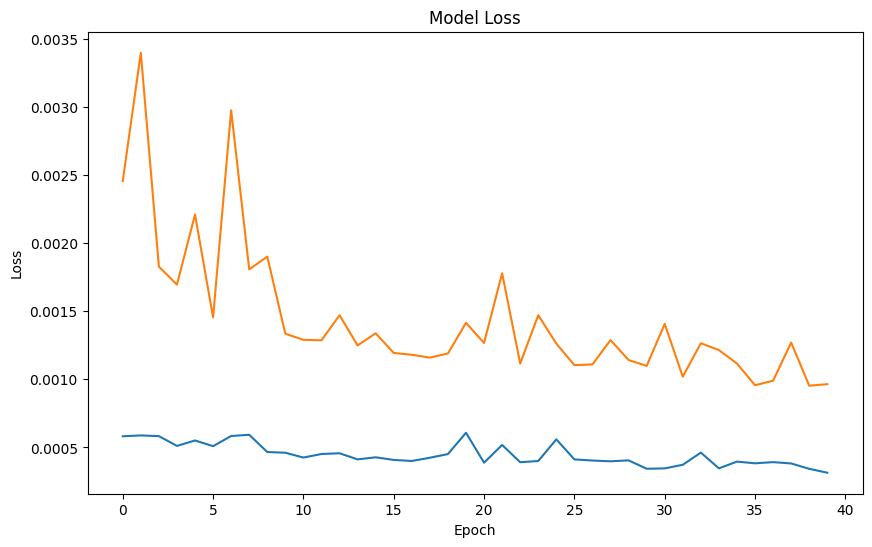

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Testing Model 1

In [ ]:
# Make predictions
train_predict_m1 = model_1.predict(X_train)
test_predict_m1 = model_1.predict(X_test)

# Inverse transform the predictions to original scale
train_predict_m1 = scaler.inverse_transform(train_predict_m1)
test_predict_m1 = scaler.inverse_transform(test_predict_m1)

# Inverse transform the y_train and y_test to original scale
y_train_m1 = scaler.inverse_transform([y_train])
y_test_m1 = scaler.inverse_transform([y_test])

# Calculate the mean squared error
train_mse_m1 = mean_squared_error(y_train_m1[0], train_predict_m1[:, 0])
test_mse_m1 = mean_squared_error(y_test_m1[0], test_predict_m1[:, 0])

print(f'Train MSE: {train_mse_m1}')
print(f'Test MSE: {test_mse_m1}')


6/6 [==============================] - 0s 4ms/step
Train MSE: 6.384558300523598
Test MSE: 20.67867801332738


## Plotting results for model 1

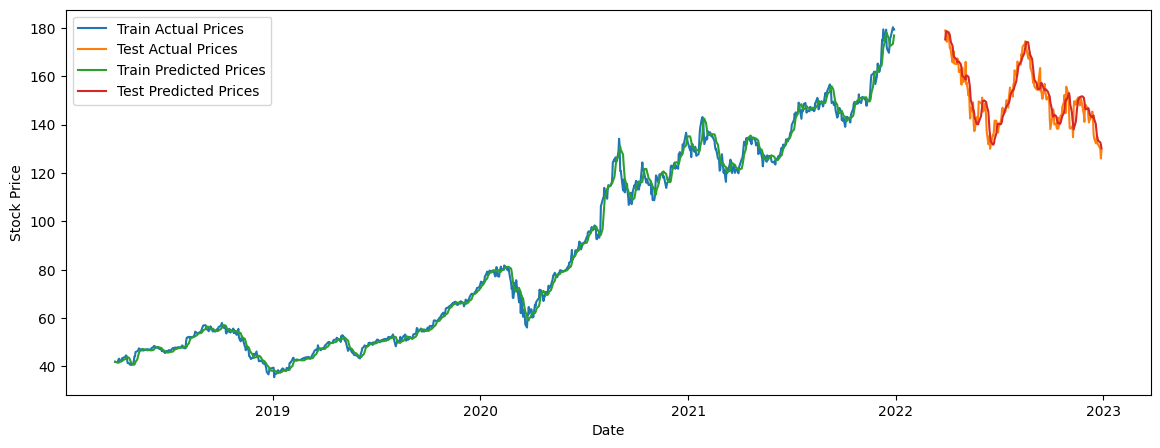

In [ ]:
# Plot the actual and predicted prices
plt.figure(figsize=(14, 5))
plt.plot(data.index[time_step:len(train_predict_m1) + time_step], scaler.inverse_transform(train_data[time_step:len(train_predict_m1) + time_step]), label='Train Actual Prices')
plt.plot(data.index[len(train_predict_m1) + (time_step * 2) + 1:len(scaled_close_prices) - 1], scaler.inverse_transform(test_data[time_step:len(test_predict_m1) + time_step]), label='Test Actual Prices')
plt.plot(data.index[time_step:len(train_predict_m1) + time_step], train_predict_m1, label='Train Predicted Prices')
plt.plot(data.index[len(train_predict_m1) + (time_step * 2) + 1:len(scaled_close_prices) - 1], test_predict_m1, label='Test Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## Building model 2

In [ ]:
# Rebuild the LSTM model with dropout
model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dropout(0.2))
model_2.add(Dense(25))
model_2.add(Dense(1))

# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error')
model_2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 25)                1275      
                                                                 
 dense_10 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 3190

## Training Model 2

Epoch 1/40
30/30 [==============================] - 4s 35ms/step - loss: 0.0214 - val_loss: 0.0027
Epoch 2/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 3/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 4/40
30/30 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 5/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 6/40
30/30 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 7/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 8/40
30/30 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 9/40
30/30 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 10/40
30/30 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 11/

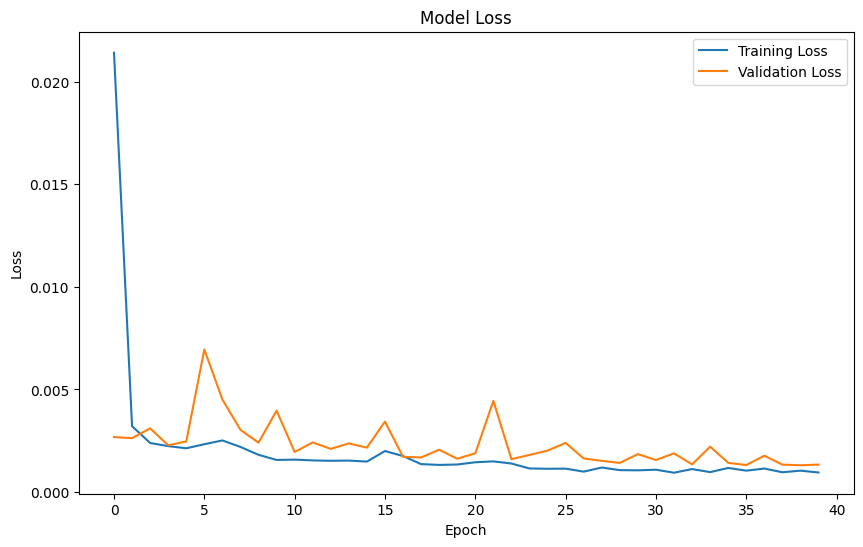

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Testing model 2

In [ ]:
# Make predictions
train_predict_m2 = model_2.predict(X_train)
test_predict_m2 = model_2.predict(X_test)

# Inverse transform the predictions to original scale
train_predict_m2 = scaler.inverse_transform(train_predict_m2)
test_predict_m2 = scaler.inverse_transform(test_predict_m2)

# Inverse transform the y_train and y_test to original scale
y_train_m2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_m2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the mean squared error
train_mse_m2 = mean_squared_error(y_train_m2, train_predict_m2)
test_mse_m2 = mean_squared_error(y_test_m2, test_predict_m2)

print(f'Improved Train MSE: {train_mse_m2}')
print(f'Improved Test MSE: {test_mse_m2}')



6/6 [==============================] - 0s 4ms/step
Improved Train MSE: 8.741953446783121
Improved Test MSE: 28.625063293538258


## Plotting results for model 2

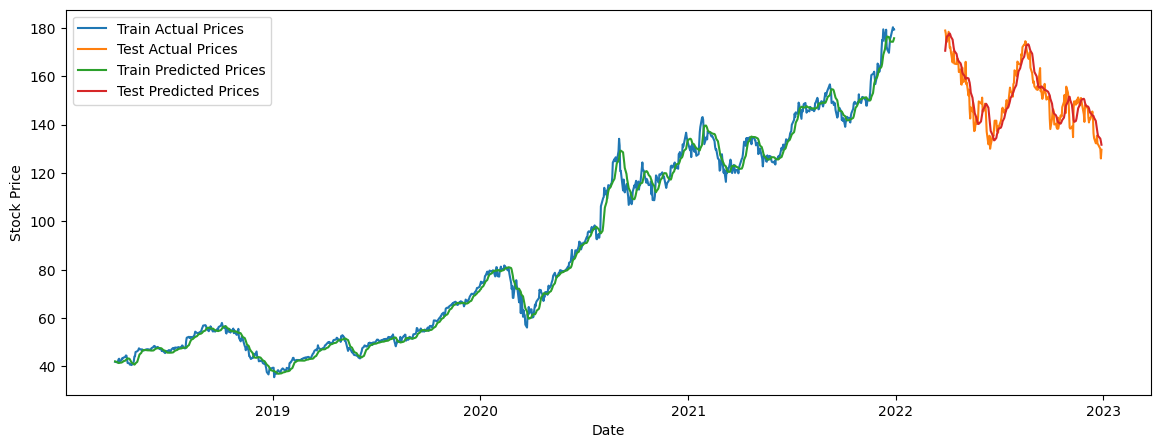

In [ ]:
# Plot the actual and predicted prices
plt.figure(figsize=(14, 5))
plt.plot(data.index[time_step:len(train_predict_m2) + time_step], scaler.inverse_transform(train_data[time_step:len(train_predict_m2) + time_step]), label='Train Actual Prices')
plt.plot(data.index[len(train_predict_m2) + (time_step * 2) + 1:len(scaled_close_prices) - 1], scaler.inverse_transform(test_data[time_step:len(test_predict_m2) + time_step]), label='Test Actual Prices')
plt.plot(data.index[time_step:len(train_predict_m2) + time_step], train_predict_m2, label='Train Predicted Prices')
plt.plot(data.index[len(train_predict_m2) + (time_step * 2) + 1:len(scaled_close_prices) - 1], test_predict_m2, label='Test Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Building model 3

In [ ]:
# Build the LSTM model
model_3 = Sequential()
# Add the first LSTM layer with 50 units and return sequences for the next layer
model_3.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
# Add the second LSTM layer with 50 units
model_3.add(LSTM(units=50))
# Add a Dense layer with 1 unit for regression
model_3.add(Dense(units=1))

# Compile the model_3 using the Adam optimizer and Mean Squared Error loss
model_3.compile(optimizer='adam', loss='mean_squared_error')

# Print the model_3 summary
model_3.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training model 3

Epoch 1/40
30/30 [==============================] - 2s 64ms/step - loss: 0.0436 - val_loss: 0.0064
Epoch 2/40
30/30 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 3/40
30/30 [==============================] - 0s 9ms/step - loss: 9.2211e-04 - val_loss: 0.0029
Epoch 4/40
30/30 [==============================] - 0s 13ms/step - loss: 8.4940e-04 - val_loss: 0.0029
Epoch 5/40
30/30 [==============================] - 0s 12ms/step - loss: 8.1125e-04 - val_loss: 0.0025
Epoch 6/40
30/30 [==============================] - 0s 13ms/step - loss: 8.3091e-04 - val_loss: 0.0026
Epoch 7/40
30/30 [==============================] - 0s 12ms/step - loss: 8.1965e-04 - val_loss: 0.0025
Epoch 8/40
30/30 [==============================] - 0s 13ms/step - loss: 7.8274e-04 - val_loss: 0.0032
Epoch 9/40
30/30 [==============================] - 0s 13ms/step - loss: 8.4568e-04 - val_loss: 0.0039
Epoch 10/40
30/30 [==============================] - 0s 14ms/step - loss: 7.0596e-0

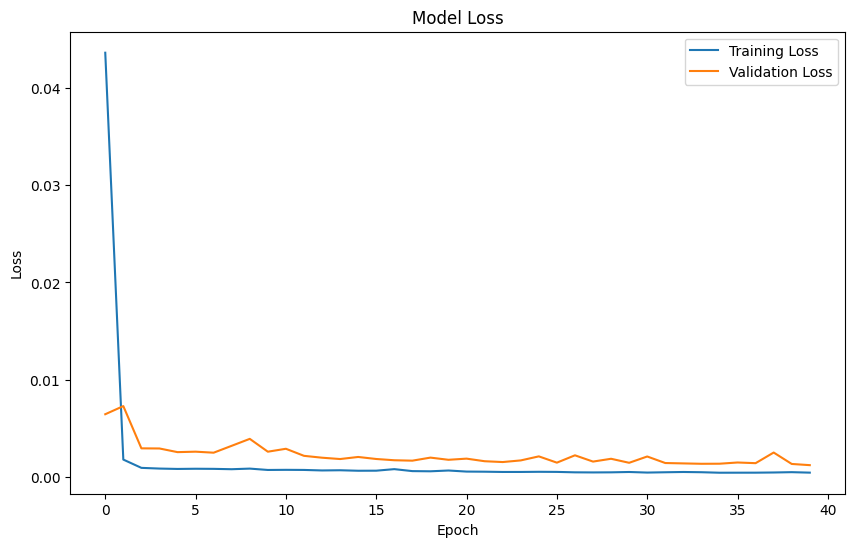

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history3 = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Make predictions
train_predict_m3 = model_3.predict(X_train)
test_predict_m3 = model_3.predict(X_test)

# Inverse transform the predictions to original scale
train_predict_m3 = scaler.inverse_transform(train_predict_m3)
test_predict_m3 = scaler.inverse_transform(test_predict_m3)

# Inverse transform the y_train and y_test to original scale
y_train_m3 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_m3 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the mean squared error
train_mse_m3 = mean_squared_error(y_train_m3, train_predict_m3)
test_mse_m3 = mean_squared_error(y_test_m3, test_predict_m3)

print(f'Train MSE: {train_mse_m3}')
print(f'Test MSE: {test_mse_m3}')


6/6 [==============================] - 0s 4ms/step
Train MSE: 8.548764659882105
Test MSE: 25.762214659702572


## Plotting results for model 3

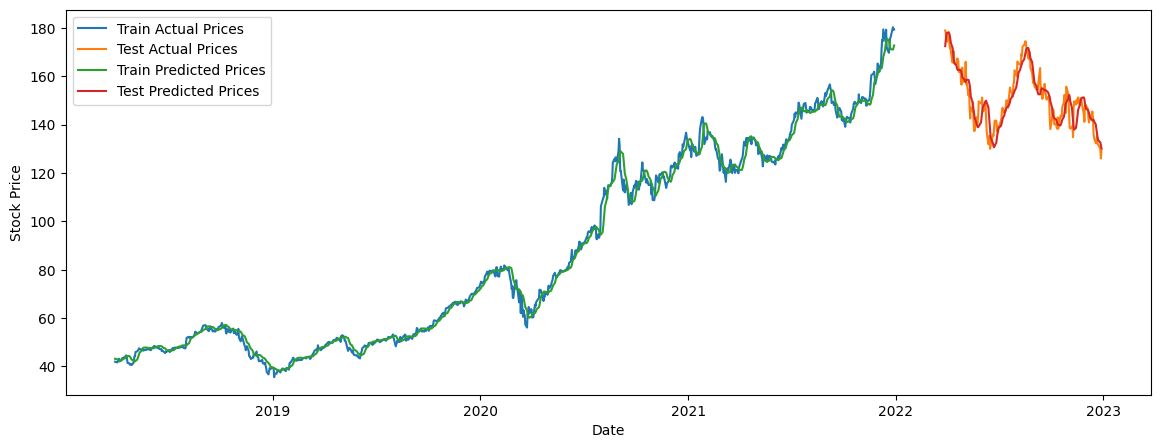

In [ ]:
# Plot the actual and predicted prices
plt.figure(figsize=(14, 5))
plt.plot(data.index[time_step:len(train_predict_m3) + time_step], scaler.inverse_transform(train_data[time_step:len(train_predict_m3) + time_step]), label='Train Actual Prices')
plt.plot(data.index[len(train_predict_m3) + (time_step * 2) + 1:len(scaled_close_prices) - 1], scaler.inverse_transform(test_data[time_step:len(test_predict_m3) + time_step]), label='Test Actual Prices')
plt.plot(data.index[time_step:len(train_predict_m3) + time_step], train_predict_m3, label='Train Predicted Prices')
plt.plot(data.index[len(train_predict_m3) + (time_step * 2) + 1:len(scaled_close_prices) - 1], test_predict_m3, label='Test Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Saving the best performing model

In [ ]:
model_1.save('LSTM_Best_Model_1.keras')